In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_curve, auc
import itertools
import json

unc_out_prefix = "ss/unc_"
pred_out_prefix = "ss/pred_"
with open(f"{pred_out_prefix}predictor_categories.json", "r") as file:
    categories = json.load(file)
max_ens_size = len(categories["S"])+1

category_order = ["S", "M", "L", "SM_duo", "SL_duo", "ML_duo"]
unc_order = ["entr", "softmax", "Entr(larger)+CE(larger||smaller)", "Entr(self)+CE(larger||smaller)"]


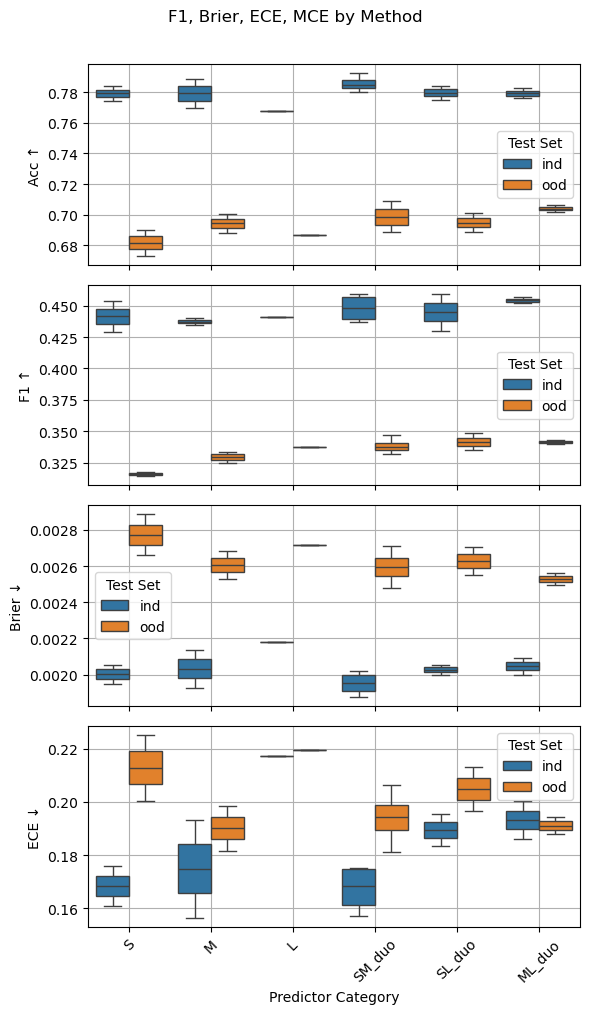

In [2]:
# Plot the metrics
metrics_df = pd.read_csv(f"{pred_out_prefix}metrics.csv")

plt.figure(figsize=(6, 10))
metrics = ['Acc','F1', 'Brier', 'ECE'] # ,'MCE'
arrows = ["↑","↑","↓","↓"]# ,"↓"
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i + 1)
    sns.boxplot(data=metrics_df, x='Predictor Category', y=metric, hue='Test Set', order=category_order,)
    plt.ylabel(metric + " " + arrows[i])
    plt.grid(True)
    if i < len(metrics) - 1:
        plt.xlabel('')  # Remove x-label for all plots except the last one
        plt.tick_params(labelbottom=False)  # Hide x-ticks and x-tick labels
    else:
        plt.xlabel('Predictor Category')  # Set x-label for the last plot
    plt.xticks(rotation=45)
plt.suptitle("F1, Brier, ECE, MCE by Method",y=1.01)
plt.tight_layout()
plt.show()

In [3]:
# Load the AUROC results dataframe
auroc_df = pd.read_csv(f"{unc_out_prefix}auroc_results.csv")
display(auroc_df)

,Predictor Category,Model,Test Set,Uncertainty Measure,AUROC
0,L,ML_duo_Resnet101ft0_Resnet152ft0,ind,Entr(self)+CE(self||smaller),0.862590
1,L,ML_duo_Resnet101ft1_Resnet152ft0,ind,Entr(self)+CE(self||smaller),0.862810
2,L,Resnet152ft0,ind,entr,0.862642
3,L,Resnet152ft0,ind,softmax,0.860148
4,L,SL_duo_Resnet50ft0_Resnet152ft0,ind,Entr(self)+CE(self||smaller),0.858866
...,...,...,...,...,...
79,SM_duo,SM_duo_Resnet50ft2_Resnet101ft0,ood,entr,0.903631
80,SM_duo,SM_duo_Resnet50ft2_Resnet101ft0,ood,softmax,0.902074
81,SM_duo,SM_duo_Resnet50ft2_Resnet101ft1,ood,Entr(larger)+CE(self||smaller),0.887975
82,SM_duo,SM_duo_Resnet50ft2_Resnet101ft1,ood,entr,0.895630


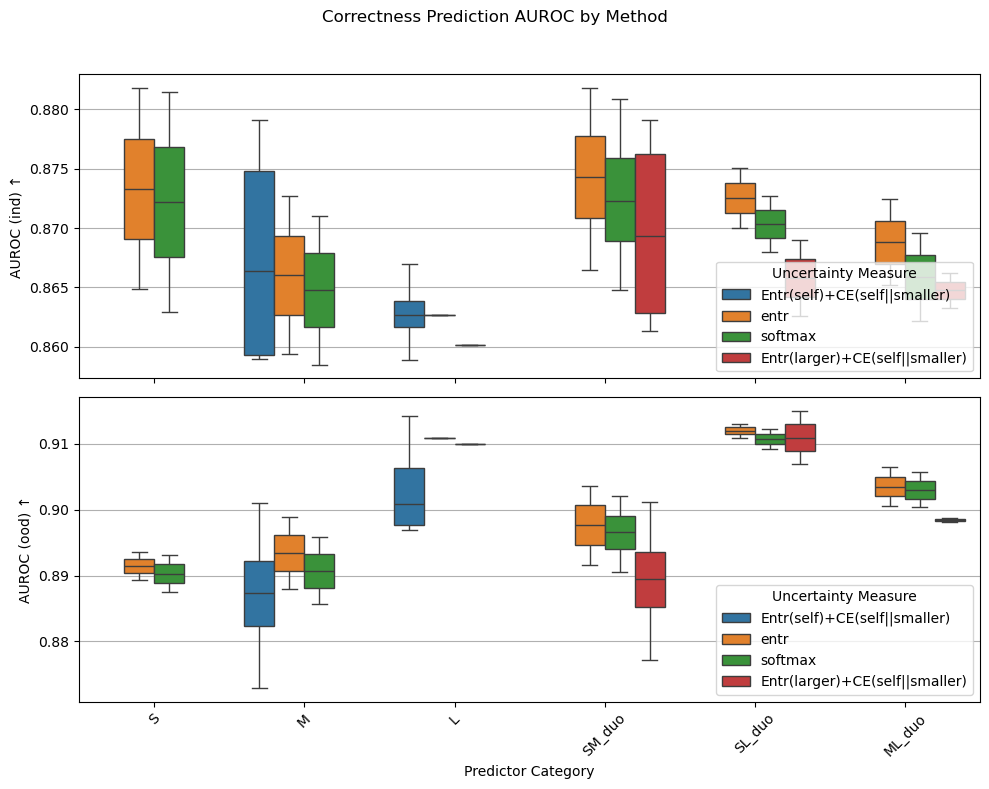

In [4]:
# Load the AUROC results dataframe
auroc_df = pd.read_csv(f"{unc_out_prefix}auroc_results.csv")

# Set up the plot
plt.figure(figsize=(10, 8))
arrows = ["↑","↑"]
# Filter data for ind and ood
auroc_df_ind = auroc_df[auroc_df['Test Set'] == 'ind']
auroc_df_ood = auroc_df[auroc_df['Test Set'] == 'ood']

# Add the overall title
plt.suptitle("Correctness Prediction AUROC by Method")
unc_order = ["entr", "softmax", "Entr(larger)+CE(larger||smaller)", "Entr(self)+CE(larger||smaller)"]
# Create subplots for ind and ood
for i, (data, title) in enumerate(zip([auroc_df_ind, auroc_df_ood], ['ind', 'ood'])):
    plt.subplot(2, 1, i + 1)
    plt.grid(True)
    sns.boxplot(data=data, x='Predictor Category', y='AUROC', hue='Uncertainty Measure',order=category_order)
    plt.ylabel(f'AUROC ({title}) {arrows[i]}')
    if i < 1:
        plt.xlabel('')  # Remove x-label for the first plot
        plt.tick_params(labelbottom=False)  # Hide x-ticks and x-tick labels
    else:
        plt.xlabel('Predictor Category')  # Set x-label for the second plot
    plt.xticks(rotation=45)
    plt.legend(title='Uncertainty Measure', loc='lower right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top to fit the suptitle
plt.show()

In [5]:
# Load the F1-Coverage AUROC results dataframe
f1_cov_df = pd.read_csv(f"{unc_out_prefix}f1_cov_auc_results.csv")
display(f1_cov_df.head())

,Predictor Category,Model,Test Set,Uncertainty Measure,F1-Cov AUC
0,L,ML_duo_Resnet101ft0_Resnet152ft0,ind,Entr(larger)+CE(larger||smaller),73.341543
1,L,ML_duo_Resnet101ft1_Resnet152ft0,ind,Entr(larger)+CE(larger||smaller),74.213089
2,L,Resnet152ft0,ind,entr,71.565166
3,L,Resnet152ft0,ind,softmax,63.546453
4,L,SL_duo_Resnet50ft0_Resnet152ft0,ind,Entr(larger)+CE(larger||smaller),73.772689


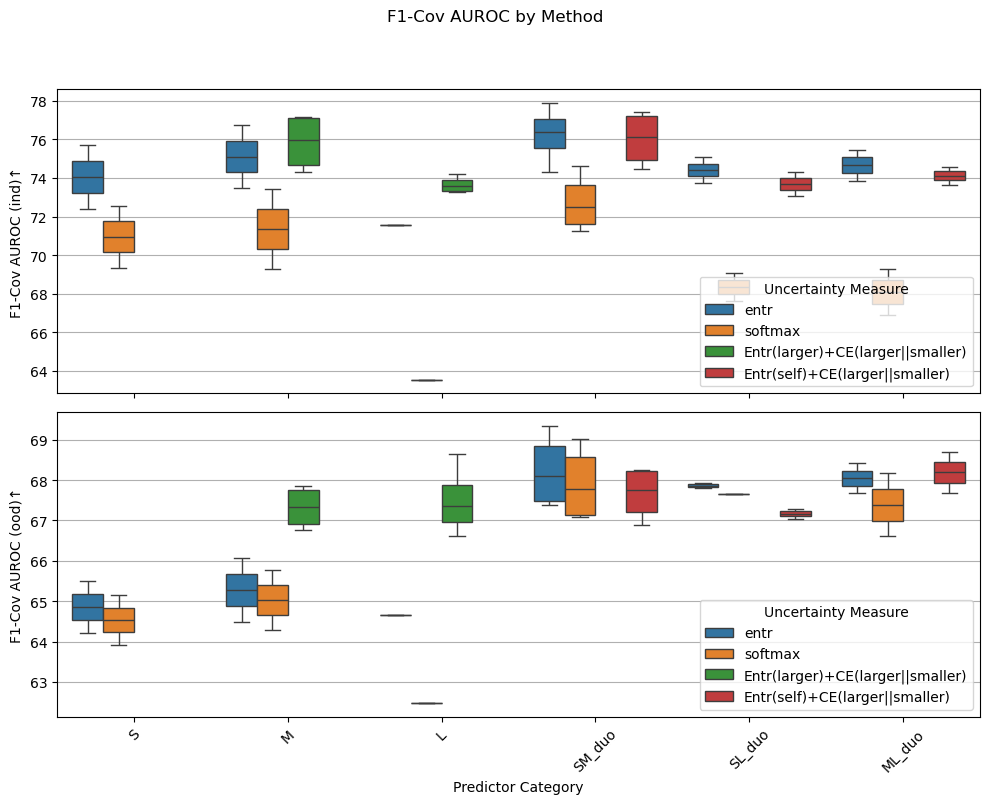

In [6]:
# Load the F1-Coverage AUROC results dataframe
f1_cov_df = pd.read_csv(f"{unc_out_prefix}f1_cov_auc_results.csv")
arrows = ["↑","↑"]
# Set up the plot
plt.figure(figsize=(10, 8))

# Filter data for ind and ood
f1_cov_df_ind = f1_cov_df[f1_cov_df['Test Set'] == 'ind']
f1_cov_df_ood = f1_cov_df[f1_cov_df['Test Set'] == 'ood']

# Add the overall title
plt.suptitle("F1-Cov AUROC by Method", y=1)

# Create subplots for ind and ood
for i, (data, title) in enumerate(zip([f1_cov_df_ind, f1_cov_df_ood], ['ind', 'ood'])):
    plt.subplot(2, 1, i + 1)
    plt.grid(True)
    sns.boxplot(data=data, x='Predictor Category', y='F1-Cov AUC', hue='Uncertainty Measure', hue_order = unc_order, order=category_order)
    plt.ylabel(f'F1-Cov AUROC ({title}){arrows[i]}')
    if i < 1:
        plt.xlabel('')  # Remove x-label for the first plot
        plt.tick_params(labelbottom=False)  # Hide x-ticks and x-tick labels
    else:
        plt.xlabel('Predictor Category')  # Set x-label for the second plot
    plt.xticks(rotation=45)
    plt.legend(title='Uncertainty Measure', loc='lower right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top to fit the suptitle
plt.show()

In [7]:
# Load the AUROC OOD results dataframe
auroc_ood_df = pd.read_csv(f"{unc_out_prefix}auroc_ood_results.csv")
display(auroc_ood_df.head())

,Predictor Category,Model,Test Set,Uncertainty Measure,AUROC OOD
0,L,ML_duo_Resnet101ft0_Resnet152ft0,combined,Entr(larger)+CE(larger||smaller),0.617089
1,L,ML_duo_Resnet101ft1_Resnet152ft0,combined,Entr(larger)+CE(larger||smaller),0.624123
2,L,Resnet152ft0,combined,entr,0.620199
3,L,Resnet152ft0,combined,softmax,0.613903
4,L,SL_duo_Resnet50ft0_Resnet152ft0,combined,Entr(larger)+CE(larger||smaller),0.631984


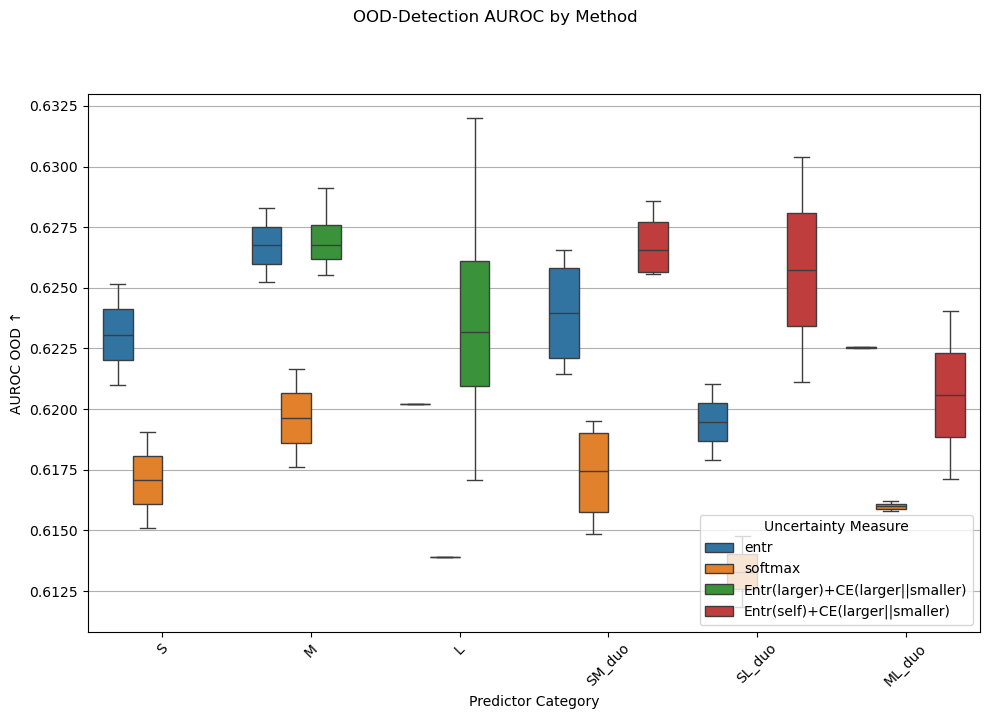

In [8]:
# Load the AUROC OOD results dataframe
auroc_ood_df = pd.read_csv(f"{unc_out_prefix}auroc_ood_results.csv")

# Set up the plot
plt.figure(figsize=(10, 7))

# Add the overall title
plt.suptitle("OOD-Detection AUROC by Method", y=1.02)
plt.grid(True)

# Create subplots for ind and ood
sns.boxplot(data=auroc_ood_df, x='Predictor Category', y='AUROC OOD', hue='Uncertainty Measure', hue_order = unc_order, order=category_order)
plt.ylabel('AUROC OOD ↑')
plt.xlabel('Predictor Category')  # Set x-label for the plot
plt.xticks(rotation=45)
plt.legend(title='Uncertainty Measure', loc='lower right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top to fit the suptitle
plt.show()